# Assignment 2
The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 

Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

In [ ]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

## Step 1: 
First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package. You are welcome to compare your own SLIC Superpixels output from assignment 1 with scikit-image SLIC output. But we would be grading the outputs in comparison to the scikit-image superpixel outputs. 

However, before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [ ]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [ ]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

Suggested algorithm: Save the superpixels along with their segmentation class

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Also Suggested would be creating a single csv with columns segment patch location, class label for each sp_i of each image.<br>




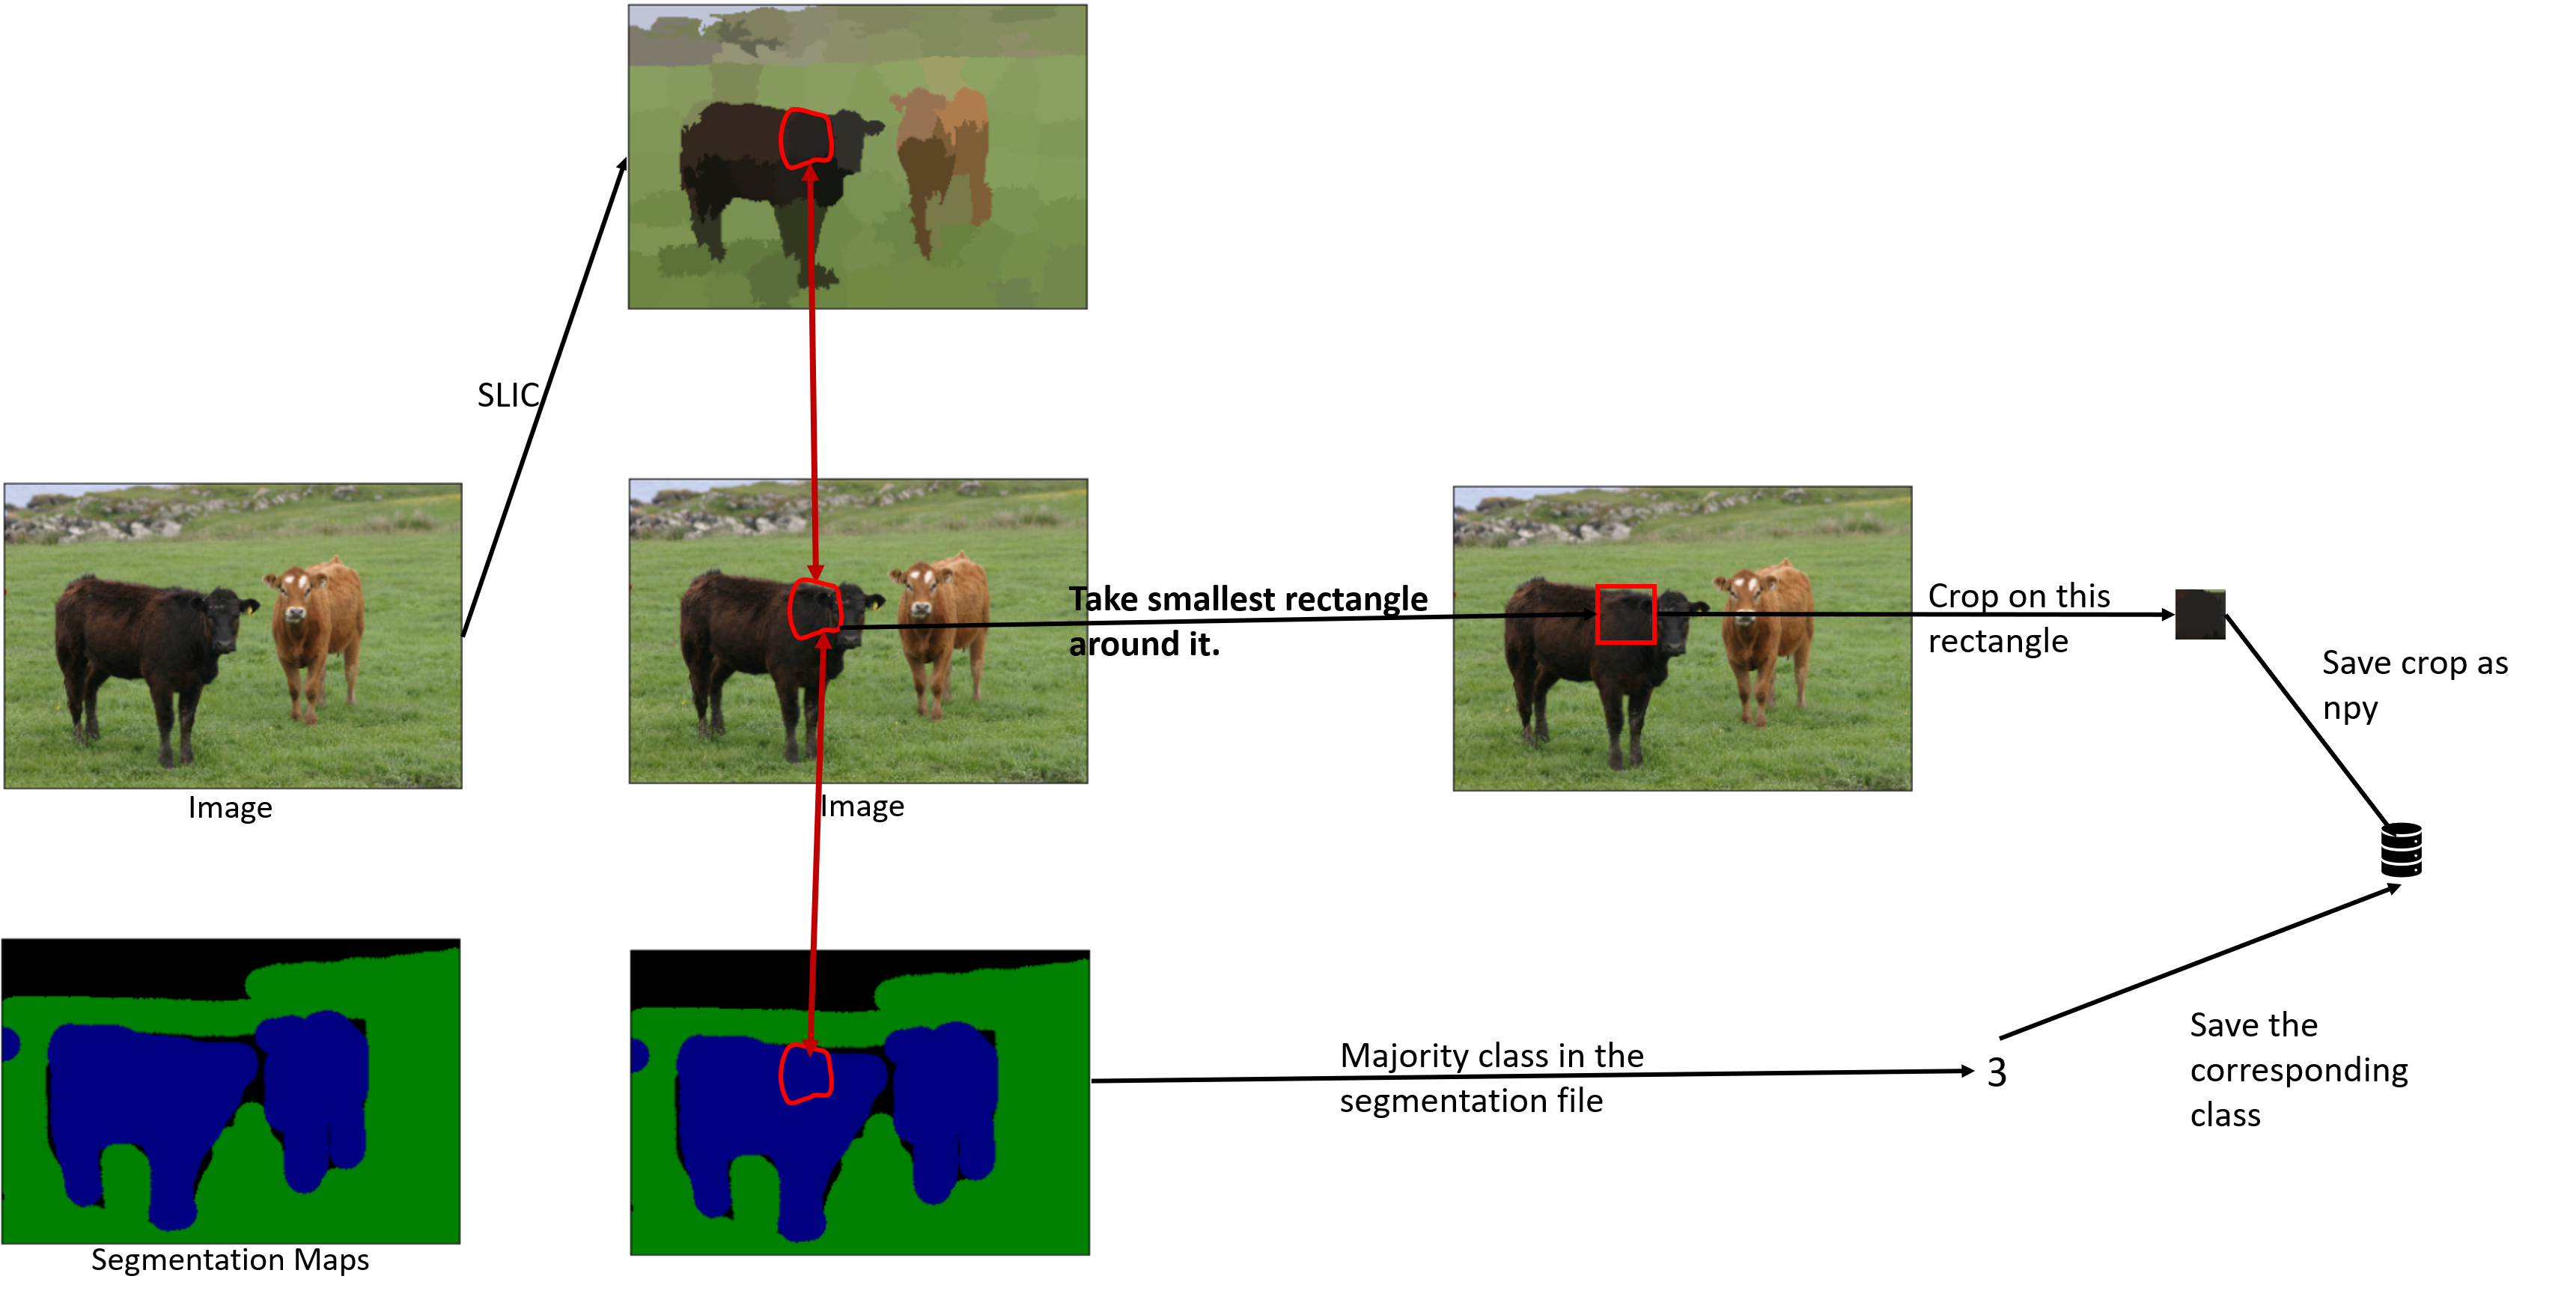

In [ ]:
from IPython.display import Image
Image(filename='data_preprocessing.png') 

In [ ]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.

if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

for filename in os.listdir(msrc_directory):
    # Your code 
    pass

Next, we define the dataset and dataloader (depends on how you define the saved rectangular patches!)

This is a dataset 

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):

    def __init__(self):
        # Your code 
        pass
            
    def __len__(self):
        # Your code 
        pass
    
    def __getitem__(self, index):
        # Your code 
        pass


## Step 2:  Now that you have dataset ready, we start to build the deep network

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [ ]:
# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):
        # Your code 
        pass
        

    def forward(self):
        # Your code 
        pass


## Step 3: 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [ ]:
# Optimizer 
class Solver(object):
    def __init__(self):
        # Your code 
        pass

    def train(self):
        # Your code 
        pass

## Putting it together:
Start to train your network and observe the loss in time.
During the inference stage, we combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map v.s. ground truth segmentation map.

In [ ]:

# load the data

# data loader

# model

# train the model


## Bonus Qs:
We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

In [ ]:
#TODO




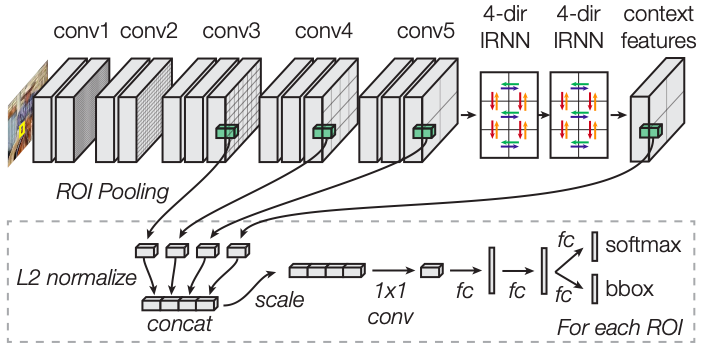

In [ ]:
from IPython.display import Image
Image(filename='/ION.png') 


2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] and the following illustration figure for an example.

In [ ]:
#TODO




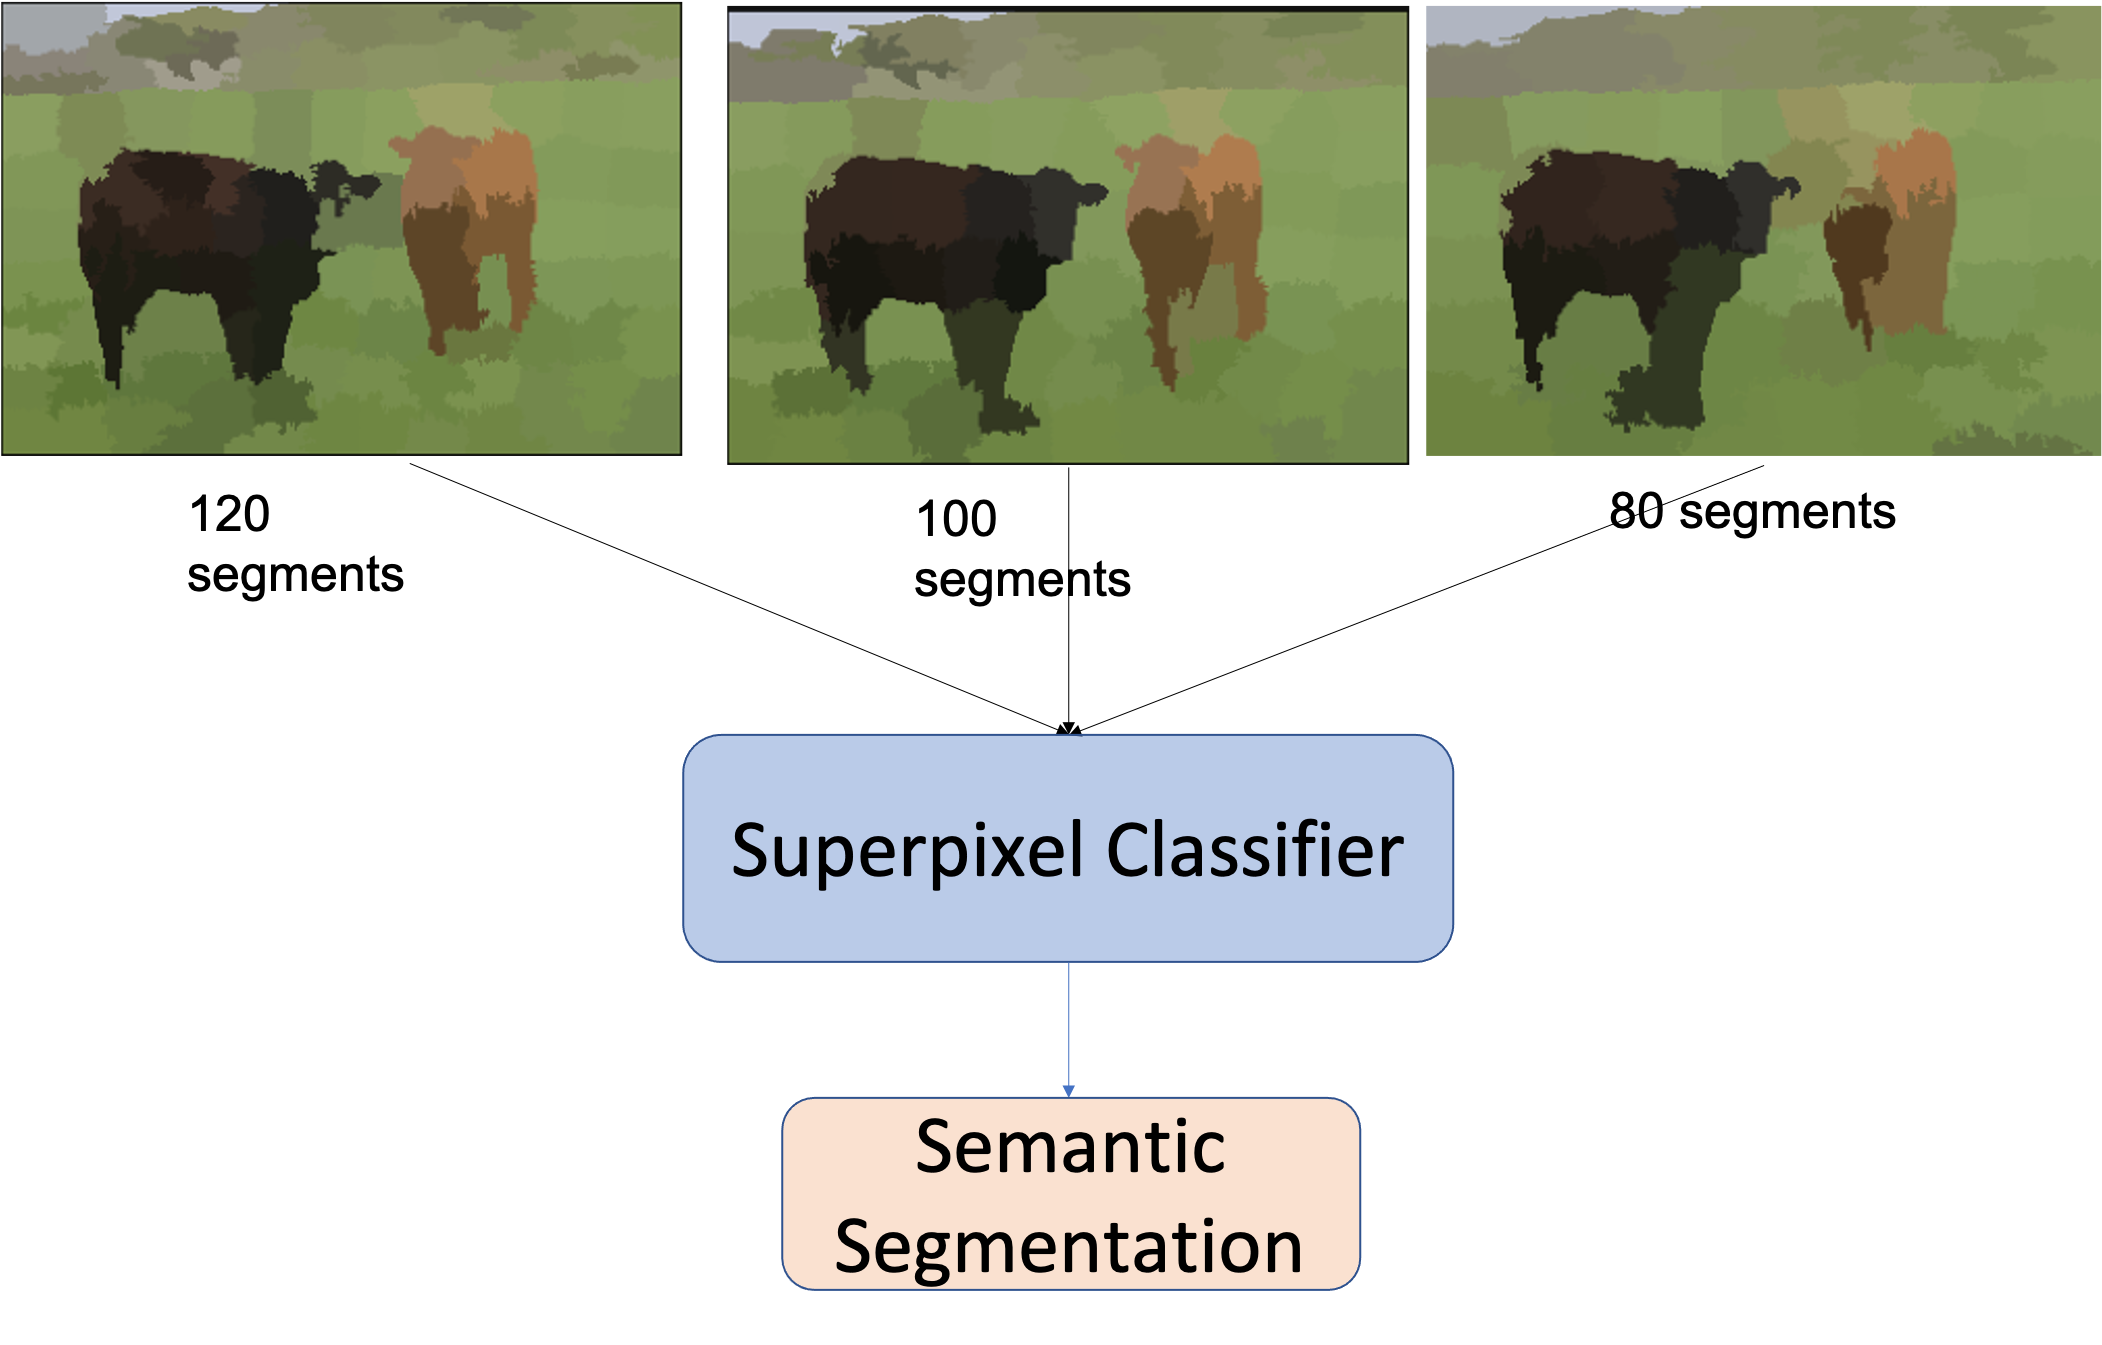

In [ ]:
from IPython.display import Image
Image(filename='/Multi-resolution.png') 

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features